In [78]:
from enum import Enum
import math


import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager


from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


from funclib.iolib import folder_open #GGM library
from funclib.baselib import pickle, unpickle #GGM library
from funclib.numericslib import roundx #GGM library
from dblib import mssql #GGM library
from plotlib.mplfuncs import FigWidthsInch #GGM library
from plotlib import qplot #GGM library

In [6]:
#GET DATAFRAME FROM SQL

In [74]:
#This loads the data from SQL Server, load the CSV dataframe here
sql="select tl_mm, lens_subj_triangle_est, abs(rotation) as rotationabs, rotation,accuracy ,hw_ratio, all_corr_rot_adj2_mm_error_perc as bias_percent, abs(all_corr_rot_adj2_mm_error_perc) as abs_bias_percent from v_mv_long_form where cnn = 'nas' and (transform like 'r%' or transform like 'none') and accuracy>0.5"

with mssql.Conn('imagedb', '(local)') as cnn:
    df_hwratio = pd.read_sql(sql, cnn)
list(df_hwratio)

['tl_mm',
 'lens_subj_triangle_est',
 'rotationabs',
 'rotation',
 'accuracy',
 'hw_ratio',
 'bias_percent',
 'abs_bias_percent']

In [8]:
#FORMAT THE DATA FOR SKLEARN CONSUMPTION, DO SOME SETUP

In [75]:
rotation = np.array(df_hwratio.rotation)
rotationabs = np.array(df_hwratio.rotationabs)
accuracy = np.array(df_hwratio.accuracy)
hw_ratio = np.array(df_hwratio.hw_ratio)
bias_percent = np.array(df_hwratio.bias_percent)
hw_bias_acc = np.c_[hw_ratio, bias_percent, accuracy, rotation]
print(hw_bias_acc.shape)

(16508, 3)


In [10]:
#Split data into train and valuation

In [11]:
train, valuation = train_test_split(hw_bias_acc, train_size=0.7, shuffle=True)
print('train.shape: %s    valuation.shape: %s' % (train.shape, valuation.shape))

train.shape: (11555, 3)    valuation.shape: (4953, 3)


C:\Python354x64\Lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
#ISOLATION FOREST ON BIAS, HWRATIO and SCORE

In [13]:
outliers_fraction = 0.2
n_samples = train.shape[0]

clf = IsolationForest(max_samples=n_samples, contamination=outliers_fraction, random_state=np.random.RandomState(28)) #the classifier
clf.fit(train)
scores_pred = clf.decision_function(train) #vector of predictions scores(floats), low values are outliers
y_pred = clf.predict(train) #vector of -1 and 1, 1=Inlier, -1=outlier
threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)
print('Model Trained')

Model Trained


In [81]:
#PLOT IT
FigWidthsInch.two_col.value

<FigWidthsInch.two_col: 7.48>

In [15]:
train_inlier = train[y_pred == 1]
train_outlier = train[y_pred == -1]

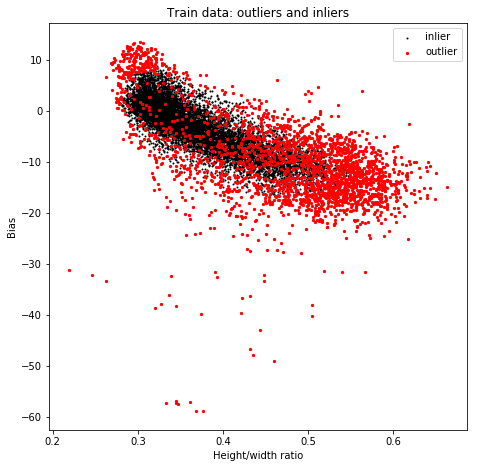

In [105]:
plt.close()
plt.figure(figsize=(FigWidthsInch.two_col.value, FigWidthsInch.two_col.value))
ax = plt.gca()
plt.title('Train data: outliers and inliers')
ax_inlier = plt.scatter(train_inlier[:,0], train_inlier[:,1], c='white', s=1, edgecolor='k', label='inlier')
ax_outlier = plt.scatter(train_outlier[:,0], train_outlier[:,1], c='r', s=5, edgecolor='r', label='outlier')
plt.legend(loc='upper right')
plt.axis('tight')
ax.set_xlabel('Height/width ratio')
ax.set_ylabel('Bias')
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/hw_bias_outliers.svg', dpi=500)
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/hw_bias_outliers.jpg')
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers')
plt.show()

In [90]:
#NOW FIT THE OTHER STUFF
train_inlier[:,2]

array([0.99919635, 0.99845862, 0.99882048, ..., 0.99947709, 0.99633253,
       0.99932337])

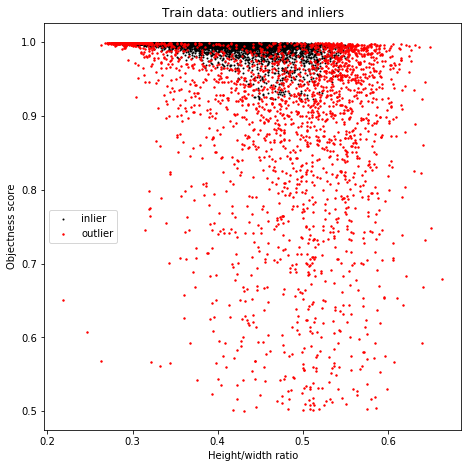

In [106]:
plt.close()
plt.figure(figsize=(FigWidthsInch.two_col.value, FigWidthsInch.two_col.value))
plt.title('Train data: outliers and inliers')
ax = plt.gca()

ax_inlier = plt.scatter(train_inlier[:,0], train_inlier[:,2], c='white', s=1, edgecolor='k', label='inlier')
ax_outlier = plt.scatter(train_outlier[:,0], train_outlier[:,2], c='r', s=2, edgecolor='r', label='outlier')
plt.legend(loc='center left')
plt.axis('tight')
ax.set_xlabel('Height/width ratio')
ax.set_ylabel('Objectness score')
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/hw_score_outliers.svg', dpi=500)
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/hw_score_outliers.jpg')
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers')
plt.show()

In [19]:
#NOW USE THE INLIERS TO TRAIN A PREDICTIVE MODEL BIAS%~HW + ACCURACY

In [20]:
np.random.seed(np.random.randint(1,100))
trainX = np.c_[train_inlier[:,0], train_inlier[:,2]]
trainY = train_inlier[:,1]




In [31]:
#Try GRADIENT BOOSTING
gbr = GradientBoostingRegressor(n_estimators=2000, max_depth=1)
gbr.fit(trainX, trainY)

#SAVE
pickle(gbr, 'C:/development/python/jupyter/mv_sklearn_forest_outliers/gradientboosting.pkl')
print('Model saved to C:/development/python/jupyter/mv_sklearn_forest_outliers/gradientboosting.pkl')



Model saved to C:/development/python/jupyter/mv_sklearn_forest_outliers/gradientboosting.pkl


In [32]:
gbr.predict(np.array([[0.7,0.9]]))

array([-13.51382584])

In [87]:
#Create the outlier model without known bias so
#we can filter out outliers in evaluation data
#THIS WILL BE USED TO PREFILTER OUTLIERS FROM THE VALUATION DATASET

In [36]:
#x_inlier = X[y_pred == 1]
filtered_hw_acc = np.c_[train_inlier[:,0], train_inlier[:,2]]

clfValuation = IsolationForest(max_samples=filtered_hw_acc.shape[0], contamination=0, random_state=np.random.RandomState(29)) #the classifier
clfValuation.fit(filtered_hw_acc)
scores_pred = clfValuation.decision_function(filtered_hw_acc)
y_pred = clfValuation.predict(filtered_hw_acc)

pickle(clfValuation, 'C:/development/python/jupyter/mv_sklearn_forest_outliers/eval_outlier_model.pkl')
print('Model saved to C:/development/python/jupyter/mv_sklearn_forest_outliers/eval_outlier_model.pkl')

Model saved to C:/development/python/jupyter/mv_sklearn_forest_outliers/eval_outlier_model.pkl


In [35]:
filtered_hw_acc.shape

(9244, 2)

In [53]:
#TEST THE OUTLIER MODEL
outlier = np.array([[0.4, 0.999], [0.4, 0.4]])
print(clfValuation.predict(outlier))

[ 1 -1]


In [57]:
valuation_hwratio_accuracy

array([[0.33202347, 0.99932647],
       [0.35429351, 0.99890804],
       [0.40247022, 0.97952384],
       ...,
       [0.36065977, 0.99852425],
       [0.30985106, 0.99922645],
       [0.55387684, 0.84351599]])

In [58]:
#VALUATION DATA - FILTER OUTLIERS
#Load pickle
valuation_hwratio_accuracy = valuation[:,[0,2]]
clfValuation = unpickle('C:/development/python/jupyter/mv_sklearn_forest_outliers/eval_outlier_model.pkl')
val_pred = clfValuation.predict(valuation_hwratio_accuracy)
valuation_inlier = valuation[val_pred == 1]
valuation_outlier = valuation[val_pred == -1]

In [60]:
print('valuation_hwratio_accuracy.shape:%s  valuation_inlier: %s,  valuation_outlier:%s' %
          (valuation_hwratio_accuracy.shape, valuation_inlier.shape, valuation_outlier.shape))

valuation_hwratio_accuracy.shape:(4953, 2)  valuation_inlier: (4660, 3),  valuation_outlier:(293, 3)


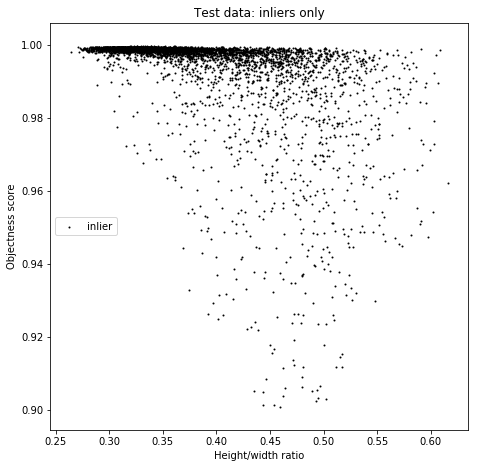

In [107]:
#VALUATION DATA - CORRECT TL ESTIMATE USING MODEL
#TODO
#valuation_inlier

valuation_inlier_filtered = valuation_inlier[valuation_inlier[:,2] > 0.9]


plt.close()
plt.figure(figsize=(FigWidthsInch.two_col.value, FigWidthsInch.two_col.value))
ax = plt.gca()
plt.title('Test data: inliers only')
ax_inlier = plt.scatter(valuation_inlier_filtered[:,0], valuation_inlier_filtered[:,2], c='white', s=1, edgecolor='k', label='inlier')
plt.legend(loc='center left')
plt.axis('tight')
ax.set_xlabel('Height/width ratio')
ax.set_ylabel('Objectness score')
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/valuation_inliers.svg', dpi=500)
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/valuation_inliers.jpg')
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers')
plt.show()

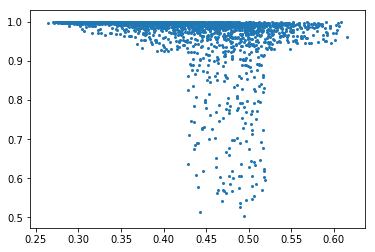

In [63]:
qplot.scatter(x_data=valuation_inlier[:,0], y_data=valuation_inlier[:,2])

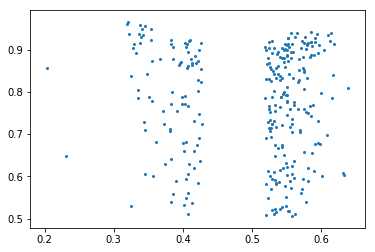

In [64]:
qplot.scatter(x_data=valuation_outlier[:,0], y_data=valuation_outlier[:,2])

In [111]:
#Load GP Model
val_for_model = valuation_inlier_filtered[:,[0,2]]
gbp = unpickle('C:/development/python/jupyter/mv_sklearn_forest_outliers/gradientboosting.pkl')
val_adj = gbp.predict(val_for_model) #THIS SHOULD CONTAIN ARE PERCENT ADJUSTMENTS

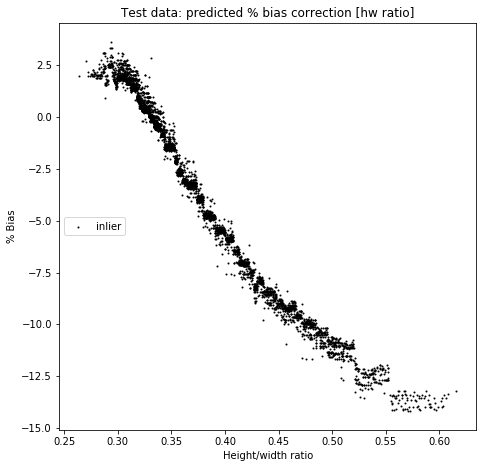

In [116]:
#qplot.scatter(val_for_model[:,0],val_adj)  #plot the inliers vs the model predicted percent adjustment

plt.close()
plt.figure(figsize=(FigWidthsInch.two_col.value, FigWidthsInch.two_col.value))
plt.title('Test data: predicted % bias correction [hw ratio]')
ax = plt.gca()
ax_inlier = plt.scatter(val_for_model[:,0], val_adj, c='white', s=1, edgecolor='k', label='inlier')
plt.legend(loc='center left')
plt.axis('tight')
ax.set_xlabel('Height/width ratio')
ax.set_ylabel('% Bias')
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/bias_adjusted_inliers_hw.svg', dpi=500)
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/bias_adjusted_inliers_hw.jpg')
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers')
plt.show()

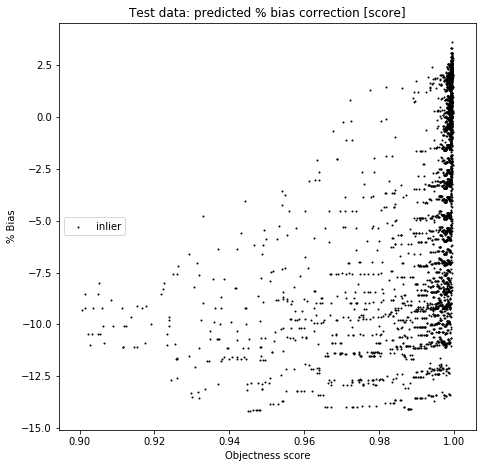

In [117]:
#qplot.scatter(val_for_model[:,0],val_adj)  #plot the inliers vs the model predicted percent adjustment

plt.close()
plt.figure(figsize=(FigWidthsInch.two_col.value, FigWidthsInch.two_col.value))
ax = plt.gca()

ax_inlier = plt.scatter(val_for_model[:,1], val_adj, c='white', s=1, edgecolor='k', label='inlier')
plt.title('Test data: predicted % bias correction [score]')
plt.legend(loc='center left')
plt.axis('tight')
ax.set_xlabel('Objectness score')
ax.set_ylabel('% Bias')
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/bias_adjusted_inliers_score.svg', dpi=500)
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers/bias_adjusted_inliers_score.jpg')
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/sklearn_forest_outliers')
plt.show()

In [72]:
ndout = np.c_[val_for_model, val_adj]
pdout = pd.DataFrame(ndout, columns=['hwratio','accuracy','bias_adj'])
pdout.to_excel('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/adjustedbias.xlsx')

array([[ 0.33202347,  0.99932647,  0.52259527],
       [ 0.35429351,  0.99890804, -2.1567572 ],
       [ 0.40247022,  0.97952384, -6.41385955],
       ...,
       [ 0.39167566,  0.9991436 , -5.31613386],
       [ 0.36065977,  0.99852425, -2.98351061],
       [ 0.30985106,  0.99922645,  1.85510344]])